D:\Anaconda\envs\my-rdkit-env\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


Mean absolute Error in koff: 0.26213 per second.
R2-score test-set: 0.849
R2-score train-set: 0.944
RMSE test-set: 0.347
RMSE train-set: 0.257
MAE test-set: 0.262
MAE train-set: 0.184
No calibration with n_samples <= 20:  consider using more n_estimators in your model,  for more accurate ci and to avoid negative values.


D:\Anaconda\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in sqrt
D:\Anaconda\envs\my-rdkit-env\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
D:\Anaconda\envs\my-rdkit-env\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


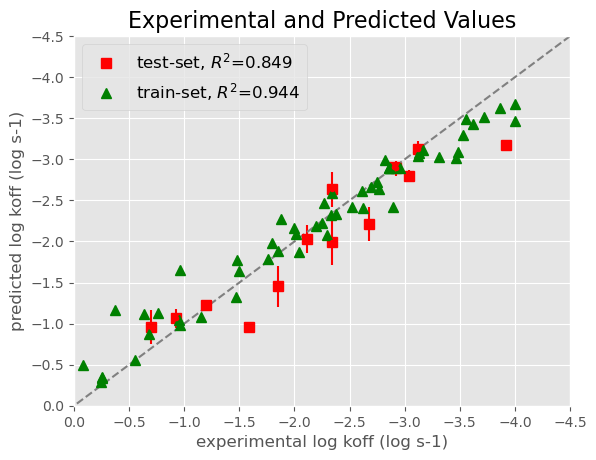

In [ ]:
## import sklearn
from sklearn import *
import pandas as pd
import numpy as np
from numpy import * 
#%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import *
from scipy.optimize import curve_fit
from sklearn.linear_model import *
from sklearn.feature_selection import RFE
from sklearn.model_selection import *
from sklearn.tree import *
import forestci as fci

#loading features from csv-files
features = pd.read_csv('Features-combined.csv', ';', usecols=['6.8','16.7','7.8','8.8','16.8','mass eigen value high','mass eigen value low','gasteiger charge eigenvalue high','gasteiger charge low','crippen lowgp eigenvalue high','crippen lowgp low','crippen mr eigenvalue high','crippen mr low','koff','MWT','valence electrons','TPSA','rotatable bonds','logP','molar refractivity','non-cyclic nitrogen','acyclic single valent nodes', 'cyclic trivalent nodes','acyclic trivalent nodes','6.6', '7.6','8.6'])
features.head(72)
features = pd.get_dummies(features, prefix_sep='_', dtype=float)#for the smiles code -> (0/1)
features.iloc[:,:].head(72)
labels = np.array(features['koff'])#labels value we want to predict
features= features.drop('koff', axis = 1)#remove the label, axis=1 is the column
feature_list = list(features.columns) #saving for later
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 7)


#Building the RondomForestGegressor
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 270,max_depth = 26,max_features = 'log2', random_state = 7)
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)

#Calculate different metrics for comparing thr ML-model
print('Mean absolute Error in koff:',round(np.mean(errors), 5), 'per second.')
predicted = rf.predict(train_features)
expected = train_labels

numerator = ((test_labels - predictions) ** 2).sum()
denominator = ((test_labels - np.average(test_labels)) ** 2).sum()
r2_score1 = 1 - (numerator / denominator)
print('R2-score test-set:',round(r2_score1,3))

numerator = ((expected - predicted) ** 2).sum()
denominator = ((expected - np.average(expected)) ** 2).sum()
r2_score2 = 1 - (numerator / denominator)
print('R2-score train-set:',round(r2_score2,3))


import math
 
MSE = np.square(np.subtract(test_labels,predictions)).mean() 
 
RMSE = math.sqrt(MSE)
print("RMSE test-set:", round(RMSE,3))

MSEt = np.square(np.subtract(expected,predicted)).mean() 
 
RMSEt = math.sqrt(MSEt)
print("RMSE train-set:", round(RMSEt,3))


from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test_labels, predictions)
print('MAE test-set:',round(MAE,3))

from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(expected, predicted)
print('MAE train-set:',round(MAE,3))

#plot the predicted and expected datapoints with errorbars
plt.style.use('ggplot')
predictions_data = pd.DataFrame(data = {'koff': test_labels, 'prediction': predictions})
x = test_labels
y = predictions_data['prediction']
mpg_V_IJ_unbiased = fci.random_forest_error(rf, train_features, test_features)
plt.errorbar(x, y, yerr=np.sqrt(mpg_V_IJ_unbiased), fmt = '.r')
plt.plot([-4.5, 0.0], [-4.5, 0.0], linestyle = '--', color = 'grey')
plt.plot(x,y,'s',markersize = 7.5, label='test-set, $R^2$=0.849', color = 'red')
plt.plot(expected, predicted, '^',markersize = 7.5, label='train-set, $R^2$=0.944', color ='green')
plt.xlim(0,-4.5)
plt.ylim(0,-4.5)
plt.xlabel('experimental log koff (log s-1)', fontsize=12)
plt.ylabel('predicted log koff (log s-1)', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.title('Experimental and Predicted Values', fontsize=16)
plt.show()

#calculating the feature importance with permutation
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
r = permutation_importance(rf, test_features, test_labels, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
#    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print('Measured with permutation:',
               (f"{feature_list[i]:24}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}"),)

#sort the features wth the standard deviations after the importance    
a = (list(feature_list))
b = list(r.importances_mean)
c = list(r.importances_std)
my_dict={}
for i in range(len(a)):
    my_dict[a[i]]= (b[i],c[i])

sorted_dictonary=sorted(my_dict.items(), key=lambda x: x[1])
sorted_keys=[k for k, v in sorted_dictonary]
sorted_errors=[v[1] for k, v in sorted_dictonary]
sorted_importance=[v[0] for k, v in sorted_dictonary]

#plot the calculated importance
plt.style.use('ggplot')
x_values = list(range(len(a)))
plt.bar(sorted_keys, sorted_importance, orientation = 'vertical', color = 'darkblue', facecolor=None, yerr=sorted_errors)
plt.xticks(x_values, rotation='vertical', fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature importances measured with permutation')
plt.show()   